# Hearthstone Cluster Project - KMeans Clustering
This project aims to use clustering algorithms on the Hearthstone decks data from Hearthpwn. In this notebook, the clustering algorithm of choice is KMeans Clustering.  
The data is obtained from history of hearthstone hosted on Kaggle [here](https://www.kaggle.com/romainvincent/history-of-hearthstone)  
History of Hearthstone dataset is scraped by the Kaggle user "romainvincent" roughly two years ago.

## Introduction and background
Hearthstone is an online trading card game where players build a deck of 30 cards and face each other. The quality of the deck heavily depends on the synergy of the cards included within the deck. Various classes and synergies availble at the players' disposal gives rise to numerous deck archetypes. These archetypes are essentially different types of decks with different win conditions or the gameplan to defeat the opponent. The cards that synergize with each other form a group of cards that if they were to be included in a deck, they have to be included togehter. This is generally known as a **pcakage**.  
This notebook aims to explore and surface these synergies through the decklist dataset.

## Approach and methodology
Each row of the data is a deck that has been posted on hearthpwn. For each deck, there are 30 cards and their card ID ("dbfId") are recorded under the columns "card_0" to "card_29". First, the 30 card columns have to be combined into one single column with all the 30 IDs of the cards within a deck. Then, a column is created for each card. If a deck contains a particular card, the value under the column of that particular card will the count of the copies of the card within the deck.  
For example, if deck number 10 has 2 copies of card 111, the value under the column "111" for deck 10 will be 2.

### Importing packages

In [138]:
from collections import Counter
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Loading data

In [139]:
refs = json.load(open("./history-of-hearthstone/refs.json"))
decks_data = pd.read_csv("./history-of-hearthstone/data.csv")

In [140]:
# taking a look at the head
decks_data.head()

,craft_cost,date,deck_archetype,deck_class,deck_format,deck_id,deck_set,deck_type,rating,title,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
0,9740,2016-02-19,Unknown,Priest,W,433004,Explorers,Tavern Brawl,1,Reno Priest,...,374,2280,2511,2555,2566,2582,2683,2736,2568,2883
1,9840,2016-02-19,Unknown,Warrior,W,433003,Explorers,Ranked Deck,1,RoosterWarrior,...,1781,1781,2021,2021,2064,2064,2078,2510,2729,2736
2,2600,2016-02-19,Unknown,Mage,W,433002,Explorers,Theorycraft,1,Annoying,...,1793,1801,1801,2037,2037,2064,2064,2078,38710,38710
3,15600,2016-02-19,Unknown,Warrior,W,433001,Explorers,None,0,Standart pay to win warrior,...,1657,1721,2018,2296,2262,336,2729,2729,2736,2760
4,7700,2016-02-19,Unknown,Paladin,W,432997,Explorers,Ranked Deck,1,Palamix,...,2027,2029,2029,2064,2078,374,2717,2717,2889,2889


## Data cleaning

### Data types of the columns
Column card_0 to card_29 are of the same type - int.

In [141]:
decks_data.dtypes[1:13]

date              object
deck_archetype    object
deck_class        object
deck_format       object
deck_id            int64
deck_set          object
deck_type         object
rating             int64
title             object
user              object
card_0             int64
card_1             int64
dtype: object

The column "date" is not of the correct type. Changing the column datatype to datetime.

In [142]:
decks_data['date'] = pd.to_datetime(decks_data['date'])

In [143]:
decks_data.dtypes[1:13]

date              datetime64[ns]
deck_archetype            object
deck_class                object
deck_format               object
deck_id                    int64
deck_set                  object
deck_type                 object
rating                     int64
title                     object
user                      object
card_0                     int64
card_1                     int64
dtype: object

### Replacing nulls under "title" with a dummy deck name

In [144]:
decks_data.isnull().sum()[decks_data.isnull().sum() != 0]

title    8
dtype: int64

There are 8 decks without title. Filling the null titles with a placeholder name

In [145]:
decks_data = decks_data.fillna('some deck')

### Exploring the number of decks by type and format

#### Total number of decks in both Wild and Standard format

In [146]:
decks = len(decks_data)
print ('Number of decks :', decks)

Number of decks : 346232


#### Total wild decks

In [147]:
wild = len(decks_data[decks_data['deck_format'] == 'W'])
print ('Wild decks:', wild)

Wild decks: 175446


#### Count of all decks by type

In [148]:
decks_data['deck_type'].value_counts()

Ranked Deck      202375
None              91058
Theorycraft       19688
Arena             14095
PvE Adventure      9059
Tavern Brawl       6360
Tournament         3597
Name: deck_type, dtype: int64

#### Count of _standard_ decks by type

In [149]:
decks_data[decks_data['deck_format'] != 'W']['deck_type'].value_counts()

Ranked Deck      101431
None              47837
Theorycraft        9644
Arena              7233
Tournament         2460
PvE Adventure      1398
Tavern Brawl        783
Name: deck_type, dtype: int64

#### Choosing only _standard_ ranked and tournament decks.

In [150]:
standard_decks = decks_data[decks_data['deck_format'] == 'S']
standard_decks = standard_decks[standard_decks['deck_type'].isin(['Ranked Deck', 'Tournament'])]
standard_decks['deck_type'].value_counts()

Ranked Deck    101431
Tournament       2460
Name: deck_type, dtype: int64

#### Histogram of the rating

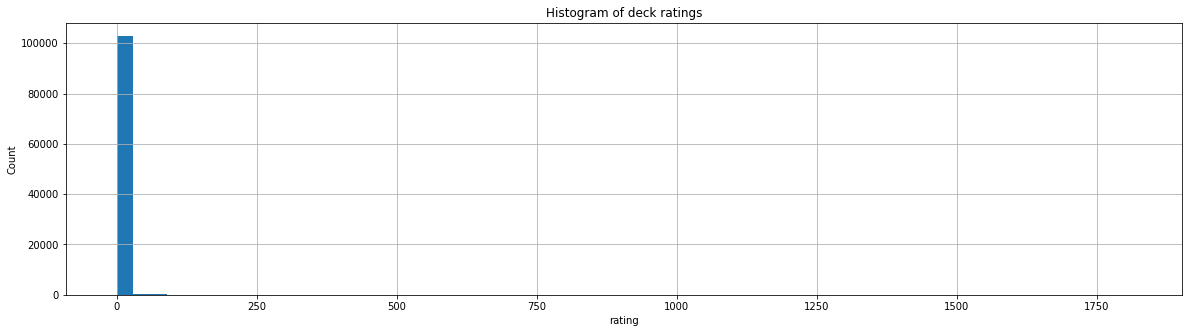

In [151]:
plt.figure(figsize=(20,5))
plt.hist(standard_decks['rating'], bins=60)
plt.title("Histogram of deck ratings")
plt.ylabel("Count")
plt.xlabel("rating")
plt.grid(True)
plt.show()

Decks with very low rating absolutely dominates the population. These decks are unlikely to be representative of the good decks that utilize package synergy too. As such, decks with low ratings are to be filtered.  

#### Examining the decks with low rating
(rating between 0-30)

Ranked Deck    100472
Tournament       2431
Name: deck_type, dtype: int64


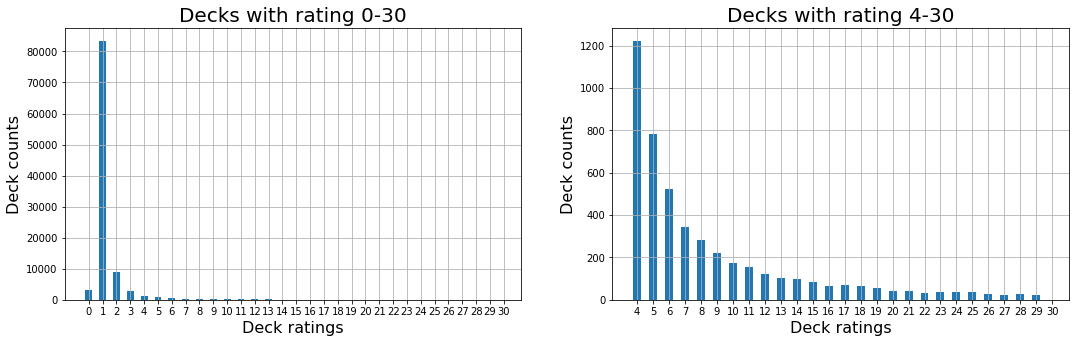

In [152]:
low_ratings = standard_decks[standard_decks['rating'] < 31]
print(low_ratings['deck_type'].value_counts())

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(18, 5))
ax1.hist(low_ratings['rating'], bins=np.arange(31)-0.25, width=0.5)
ax1.grid()
ax1.set_xticks(range(0,31))
ax1.set_title("Decks with rating 0-30", fontsize=20)
ax1.set_xlabel("Deck ratings", fontsize=16)
ax1.set_ylabel("Deck counts", fontsize=16);

ax2.hist(low_ratings[low_ratings['rating'] > 3]['rating'], bins=np.arange(4,31)-0.25, width=0.5)
ax2.grid()
ax2.set_xticks(range(4,31))
ax2.set_title("Decks with rating 4-30", fontsize=20)
ax2.set_xlabel("Deck ratings", fontsize=16)
ax2.set_ylabel("Deck counts", fontsize=16);

The population of decks appear to be less skewed at rating value > 20. Hence, only decks with rating > 20 are considered in this study.  
Looking at rated decks' columns.

## Feature Engineering

### Creating the "card" columns
First, the card IDs from card_0 to card_29 need to be combined into one space separated sentence to later generate the card counts for each card in a deck.

In [153]:
rated_decks = standard_decks[standard_decks['rating'] > 20].copy()
rated_decks.columns

Index(['craft_cost', 'date', 'deck_archetype', 'deck_class', 'deck_format',
       'deck_id', 'deck_set', 'deck_type', 'rating', 'title', 'user', 'card_0',
       'card_1', 'card_2', 'card_3', 'card_4', 'card_5', 'card_6', 'card_7',
       'card_8', 'card_9', 'card_10', 'card_11', 'card_12', 'card_13',
       'card_14', 'card_15', 'card_16', 'card_17', 'card_18', 'card_19',
       'card_20', 'card_21', 'card_22', 'card_23', 'card_24', 'card_25',
       'card_26', 'card_27', 'card_28', 'card_29'],
      dtype='object')

In [154]:
# Adding the first card to the "card" column. The first card is card_0.
rated_decks.loc[:, 'card'] = rated_decks.loc[:, 'card_0'].astype(int).astype(str)

# for card_1 to card_29, concatenate the card ID to the existing 'card' column.
for i in range(1,30):
    colname = 'card_' + str(i)
    rated_decks.loc[:, 'card'] = rated_decks.loc[:, 'card'] + ' ' + rated_decks[colname].astype(int).astype(str)

In [155]:
# checking the head of the dataframe
rated_decks["card"].head()

137     180 180 306 459 461 461 559 573 667 667 749 82...
1690    64 64 95 137 137 254 254 734 825 825 1035 1124...
2414    28 28 1007 1007 242 304 304 401 401 511 511 53...
3527    296 296 437 437 519 699 141 1003 1003 1093 124...
3992    36 64 64 95 95 137 137 254 254 503 503 825 825...
Name: card, dtype: object

In [156]:
# column "card" generated successfully. Dropping card_0 to card_29 columns.
rated_decks.drop(['card_0',
       'card_1', 'card_2', 'card_3', 'card_4', 'card_5', 'card_6', 'card_7',
       'card_8', 'card_9', 'card_10', 'card_11', 'card_12', 'card_13',
       'card_14', 'card_15', 'card_16', 'card_17', 'card_18', 'card_19',
       'card_20', 'card_21', 'card_22', 'card_23', 'card_24', 'card_25',
       'card_26', 'card_27', 'card_28', 'card_29'], axis=1, inplace=True)
rated_decks.head()

,craft_cost,date,deck_archetype,deck_class,deck_format,deck_id,deck_set,deck_type,rating,title,user,card
137,8120,2016-02-19,Miracle Rogue,Rogue,S,432773,Explorers,Ranked Deck,303,Standard Miracle Rogue,Genelll,180 180 306 459 461 461 559 573 667 667 749 82...
1690,8180,2016-04-21,Ramp Druid,Druid,S,478188,Explorers,Ranked Deck,87,*Updated* C'Thun Ramp (Anti-Meta),seksireturns,64 64 95 137 137 254 254 734 825 825 1035 1124...
2414,1680,2016-04-30,Unknown,Warrior,S,520990,Old Gods,Ranked Deck,66,Pirate Aggro Warrior (Top 500 Legend EU),Robinette42,28 28 1007 1007 242 304 304 401 401 511 511 53...
3527,1860,2016-04-30,Midrange Hunter,Hunter,S,520585,Old Gods,Ranked Deck,512,[Spark] Beast Master (S25),Sparkaz,296 296 437 437 519 699 141 1003 1003 1093 124...
3992,8260,2016-06-27,Yogg Druid,Druid,S,579170,Old Gods,Ranked Deck,25,[Rank 9 to Legend in 11 Hours] Yogg/Token Drui...,HS_KerneL,36 64 64 95 95 137 137 254 254 503 503 825 825...


The column "card" now contains 30 card IDs for the cards within the deck.

### Creating columns containing the counts of each card

### Cards details from JSON
JSON file contains the names and IDs of all the cards. This JSON file will be used to obtain the list of all card IDs.

In [157]:
card_data = pd.DataFrame.from_records(refs)

# dropping cards without dbfId
card_data = card_data[~card_data['dbfId'].isna()]

# casting the dbfId to integer instead of float
card_data['dbfId'] = card_data['dbfId'].astype(int)

card_data.head()

,artist,attack,cardClass,collectible,cost,dbfId,flavor,health,id,name,...,targetingArrowText,durability,entourage,faction,overload,spellDamage,hideStats,classes,multiClassGroup,collectionText
0,Jakub Kasper,4.0,NEUTRAL,True,4.0,2518,The crowd ALWAYS yells lethal.,4.0,AT_121,Crowd Favorite,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,4.0,NEUTRAL,NaN,6.0,1769,NaN,7.0,CRED_09,Ben Thompson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NEUTRAL,NaN,NaN,10081,NaN,NaN,TB_007e,Deviate Switch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mauricio Herrera,3.0,WARRIOR,True,3.0,40569,"""I don't know a lot about used GvG cards, so I...",3.0,CFM_755,Grimestreet Pawnbroker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ittoku,2.0,NEUTRAL,True,4.0,1370,His dreams of flying and breathing fire like h...,7.0,CS2_119,Oasis Snapjaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
# reading the column names
card_data.columns

Index(['artist', 'attack', 'cardClass', 'collectible', 'cost', 'dbfId',
       'flavor', 'health', 'id', 'name', 'playerClass', 'rarity',
       'referencedTags', 'set', 'text', 'type', 'elite', 'mechanics',
       'howToEarnGolden', 'race', 'playRequirements', 'howToEarn',
       'targetingArrowText', 'durability', 'entourage', 'faction', 'overload',
       'spellDamage', 'hideStats', 'classes', 'multiClassGroup',
       'collectionText'],
      dtype='object')

In [159]:
# reading the shape, 3116 cards in total
card_data.shape

(3116, 32)

In [160]:
# obtaining a list of all card IDs in the reference card data
card_ids = card_data['dbfId'].astype(str).tolist()

In [161]:
def contains(cardlist, card):
    '''
    A functiont to check how many times a card ID ("dbfId")
    appear in the cardlist under "card" column.
    '''
    cardcount = Counter(cardlist.split())[card]
    return cardcount

In [162]:
# for every card in the cardlist, check if it is present in the card column.
# Then add the count (0,1 or 2) onder the respective card's column

for i in (card_ids):
    rated_decks.loc[:,i] = rated_decks.loc[:,'card'].apply(lambda x: contains(x,i))

In [163]:
# remove any card column that does not have a card present in the decks at all.
# That is, the value of the column is 0 for every row.

rated_decks = rated_decks.loc[:, (rated_decks != 0).any(axis=0)]
rated_decks.head()

,craft_cost,date,deck_archetype,deck_class,deck_format,deck_id,deck_set,deck_type,rating,title,...,39119,2782,2949,40839,38426,919,1135,1064,140,41841
137,8120,2016-02-19,Miracle Rogue,Rogue,S,432773,Explorers,Ranked Deck,303,Standard Miracle Rogue,...,0,0,0,0,0,0,0,0,0,0
1690,8180,2016-04-21,Ramp Druid,Druid,S,478188,Explorers,Ranked Deck,87,*Updated* C'Thun Ramp (Anti-Meta),...,0,0,0,0,0,0,0,0,0,0
2414,1680,2016-04-30,Unknown,Warrior,S,520990,Old Gods,Ranked Deck,66,Pirate Aggro Warrior (Top 500 Legend EU),...,0,0,0,0,0,0,0,0,0,0
3527,1860,2016-04-30,Midrange Hunter,Hunter,S,520585,Old Gods,Ranked Deck,512,[Spark] Beast Master (S25),...,0,0,0,0,0,0,0,0,0,0
3992,8260,2016-06-27,Yogg Druid,Druid,S,579170,Old Gods,Ranked Deck,25,[Rank 9 to Legend in 11 Hours] Yogg/Token Drui...,...,0,0,0,0,0,0,0,0,0,0


In [164]:
# saving processed data
rated_decks.to_csv('processed_HS_data.csv')

Checking if all the cards in a deck add up.

In [165]:
rated_decks.loc[:, 'cardsaddup'] = rated_decks.iloc[:,12:].sum(axis=1) == 30
rated_decks['cardsaddup'].sum() == len(rated_decks)

True

## Applying KMeans clustering on both decks and cards
The most straightforward method of clusterning appears to be KMeans clustering. Here, for clustering of decks, the number of clusters used is 20 which is an approximate. For clustering of cards, the n value used is 30. Fine tuning of the n value will be done in a later section.

In [166]:
from sklearn.cluster import KMeans

### Clustering the decks together
----

Here, KMeans clustering is used to cluster the decks together based on their card choices. The expected results would be group of similar decks and the corresponding cards they have in common.

In [167]:
# the array clusters_decks now contains the number of the cluster the deck belongs to
clusters_decks = KMeans(n_clusters=20, random_state=7).fit_predict(rated_decks.iloc[:,12:])
print(clusters_decks)

[ 1  4 14 ... 13  1  3]


#### Visualizing the data
Heatmap appears to be the most straightforward way to visualize the data. The decks are on the y-axis. To improve the interpretability, the deck IDs are replaced by the deck archetypes. Deck archetypes are used instead of the deck names since they are more intuitive when it comes to describing type of a deck.  
x-axis are the card names. The heatmap will be sorted in order of cards frequency. That is, the card that appears the most among the decks within the cluster will be on the leftmost of the axis.

In [168]:
# this lookup table will be used to translate card IDs to names
# the keys are integer. They have to be changed to string
card_lookup = card_data.set_index('dbfId')['name']
card_lookup = {str(k):v for k,v in card_lookup.items()}

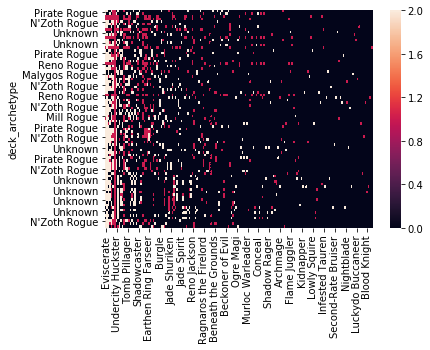

In [169]:
# plotting the heat map of cluster number 1
cluster_number = 3
cluster_1 = rated_decks[clusters_decks == cluster_number].iloc[:,12:].astype(float)

# rename the rows (index)
cluster_1.set_index([rated_decks[clusters_decks == cluster_number].iloc[:,2]], inplace=True)

# rename the columns
cluster_1.rename(columns=dict(card_lookup), inplace=True)

# drop all clumns with no card present in the decks in the cluster
cluster_1 = cluster_1.loc[:, (cluster_1 != 0).any(axis=0)]

# sort the columns by their sum
cluster_1 = cluster_1.reindex(cluster_1.sum().sort_values(ascending=False).index, axis=1)

sns.heatmap(cluster_1)

### Discussion
Here, we can see the all the Rogue decks are clustered together. Moreover, the main variant appears to be a N'Zoth Rogue. Two copies of strong Rogue cards, preferably with deathrattle, such as Eviscerate, Undercity Huckster, and Tomb Pillager are included in almost all the decks in this cluster.  
This demonstrates that the approach works. However, clustering the decks is not as useful as clustering the cards together. As such, clustering the cards will be the next and main appraoch of this project.

### Clustering the _cards_ together ###
----

Similar to clustering the decks done above, this section explores clustering of the cards using the decks as features. Through this, we can explore what cards frequently appear together and hence the cards that apear together can be considered a **package**.

### Reformatting the data
From rows of decks with cards as features to rows of cards with the decks they are found in as the features

In [170]:
# transpose the table

rated_decks_tpsd = rated_decks.drop(['cardsaddup'], axis=1)
rated_decks_tpsd = rated_decks_tpsd.iloc[:,12:]
rated_decks_tpsd = rated_decks_tpsd.T
print(rated_decks_tpsd.shape)

# creading a deck archetype lookup dictionary
deck_lookup = rated_decks['deck_archetype']

(782, 1296)


In [171]:
# changing the dbfId type form integer to string
card_data['dbfId'] = card_data['dbfId'].astype(int).astype(str)

# joining the card name on dbfId
rated_decks_tpsd = pd.merge(rated_decks_tpsd, card_data[['dbfId','name']], how='left', left_index=True, right_on='dbfId')

# set the index to be the card name
rated_decks_tpsd.set_index('name', inplace=True)

# drop dfbId column
rated_decks_tpsd.drop(['dbfId'], axis=1, inplace=True)

rated_decks_tpsd.head()

,137,1690,2414,3527,3992,4592,4965,5269,5327,5358,...,325935,325937,326209,330402,331034,334031,335601,336843,345826,346203
name,,,,,,,,,,,,,,,,,,,,,
Oasis Snapjaw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Shadow Word: Death,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Silent Knight,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Unlicensed Apothecary,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Shadow Madness,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Saving card-deck data
This dataset has rows as cards and the decks that contain them as features

In [173]:
rated_decks_tpsd.to_csv("cards-decks.csv")

### kmeans clustering ###

In [174]:
kmeansclf = KMeans(n_clusters=30, random_state=7)
clusters_cards = kmeansclf.fit_predict(rated_decks_tpsd)

In [175]:
def hs_heatmap(data,clusters,clusternumber):
    '''
    A function that produces a heatmap given the dataset, the KMeans model, and the predicted clusters.
    '''
    # subsetting the desired cluster
    card_cluster = data[clusters == clusternumber]#.astype(float)
    
    # sort the columns by their sum
    card_cluster = card_cluster.reindex(card_cluster.sum().sort_values(ascending=False).index, axis=1)
    card_cluster.rename(columns=dict(deck_lookup), inplace=True)
    
    # drop all clumns with no deck present in the decks in the cluster
    card_cluster = card_cluster.loc[:, (card_cluster != 0).any(axis=0)]
    
    # sort all rows by their sum
    sorted_index = card_cluster.sum(axis=1).sort_values(ascending=False)
    card_cluster = card_cluster.loc[sorted_index.index]
    
    sns.heatmap(card_cluster)

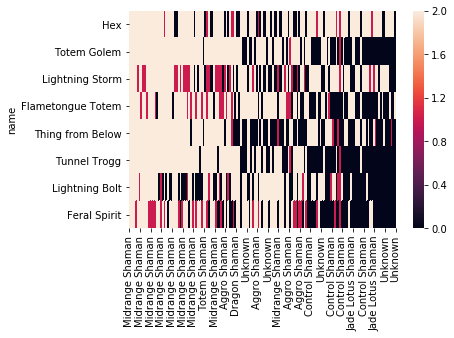

In [176]:
hs_heatmap(rated_decks_tpsd, clusters_cards, 3)

### Discussion
The heatmap above shows that KMeans clustering is effective at grouping the cards that frequently appear in the same deck togehter. In the example above, the heatmap shows a **package** of Shaman cards. These are the cards that appear together mostly in Midrange Shaman decks. They are Hex, Totem Golem, Lightning Storm, Flametongue Totem, Thing from Below, Tunnel Trogg, Lightining Bolt and Feral Spirit. These cards synergize well together using the Totem tribe and overload effects.

## Fine-tuning the model
To find the optimal n value, root mean squared distance is used to measure the tightness of a cluster. This root mean squared value is then used to measure how well the cards are clustered together.

In [177]:
def rmsqdist(data,classifier,classifier_output):
    '''
    Calculating the root mean square distance for each cluster
    '''
    clusters = []
    intra_msqdist = []
    num_cards = []
    nclusters = classifier.get_params()['n_clusters']
    for n in range(0, nclusters):
        clsutercentroid = classifier.cluster_centers_[n]
        cards_in_cluster_n = data[classifier_output == n].copy()
        card_num = len(cards_in_cluster_n)
        
        # use the norm function to obtain the root squared distance
        cards_in_cluster_n.loc[:, 'dist-from-centroid'] = cards_in_cluster_n.apply(
            lambda x: np.linalg.norm(x - clsutercentroid), axis=1)
        # finding the mean value
        average_dist = np.mean(cards_in_cluster_n['dist-from-centroid'])
        clusters.append(n)
        intra_msqdist.append(average_dist)
        num_cards.append(card_num)
    return clusters, intra_msqdist, num_cards

#### Beyond root mean suqared
As the number of clusters increase, the root mean squared distance decreases. Given the context of this project, **a package** refers to at least 2 cards working together. As such, even if the mean squared distance is low, a singleton cluster is not desirable. Therefore, the optimal model for this situation would be one where the root mean squared distance is low yet there is minimal number of singletons clusters.  
Hence, we look for an "elbow" in the plot of the number of singletons against the number of KMeans cluster. That n value is then used as the optimal number of clusters.  
In addition, the inertia value will also be taken into consideration below.

In [178]:
# looping through different number of cluster for KMeans, saving the key parameters each time.
k_vals = []
k_inertia = []
mean_dist = []
singletons = []
for k in range(10,60):
    kmeansclf = KMeans(n_clusters=k, n_init=30, random_state=7)
    clusters_cards = kmeansclf.fit_predict(rated_decks_tpsd)
    clusters, avgdist, num_cards = rmsqdist(rated_decks_tpsd, kmeansclf, clusters_cards)
    summary = pd.DataFrame({'clusters' : clusters, 'avgdist' : avgdist, 'num_cards' : num_cards}).set_index('clusters')
    mean_dist_for_k = np.mean(summary[summary['num_cards'] >= 2]['avgdist'])
    singleton = len(summary[summary['num_cards'] == 1])
    k_vals.append(k)
    k_inertia.append(kmeansclf.inertia_)
    mean_dist.append(mean_dist_for_k)
    singletons.append(singleton)
    k_vals, mean_dist, singletons

In [179]:
# fitting a smooth curve for the number of singletons.

singletons_fit = []
p = np.poly1d(np.polyfit(k_vals,singletons,5))
for i in k_vals:
    singletons_fit.append(p(i))

### Visualizing the Elbow
Plotting all the parameters above against the number of clusters

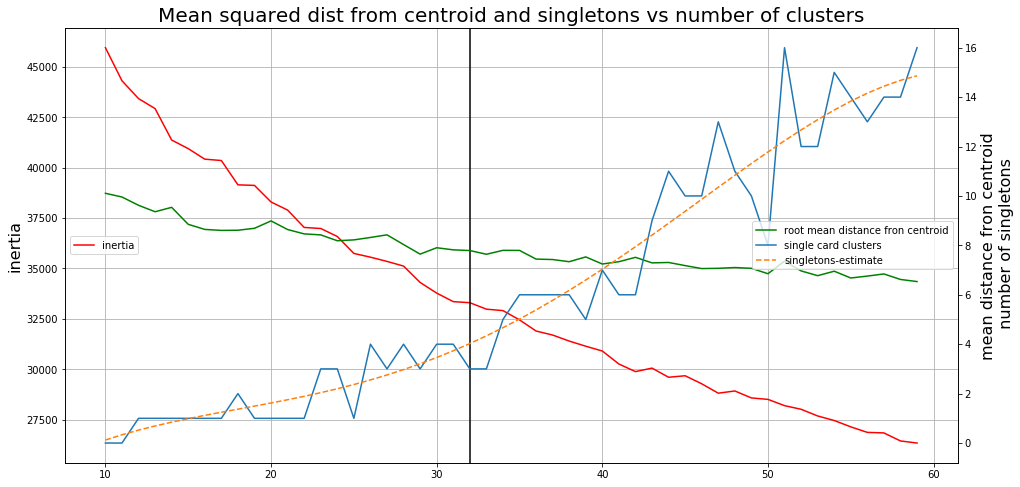

In [180]:
fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx()

ax1.plot(k_vals, k_inertia, label='inertia', c='red')
ax1.set_ylabel("inertia", fontsize=16)
ax2.plot(k_vals, mean_dist, label='root mean distance fron centroid', c='g')
ax2.set_ylabel("mean distance fron centroid\n number of singletons", fontsize=16)
ax2.plot(k_vals, singletons, label='single card clusters')
ax2.plot(k_vals, singletons_fit, linestyle='--', label='singletons-estimate')
ax1.legend(loc='center left')
ax2.legend(loc='right')
ax1.axvline(x=32, c='black')
ax1.grid()
ax1.set_title("Mean squared dist from centroid and singletons vs number of clusters", fontsize=20);

### The optimal model
From above, the best value of n seems to be approximately **32**. No strong elbow effect is observed and hence the value of 32 is derived from the number of clusters where the number of singletons start to rise sharply.  
Running the KMeans clustering one more time with n=32. Also, since **packages** are a handful of cards that are used together. The final result of this clustering exercise will be a list of **packages** with cards between 2 to 15 cards (half a deck).

In [181]:
kmeansclf = KMeans(n_clusters=32, n_init=50, random_state=7)
clusters_cards = kmeansclf.fit_predict(rated_decks_tpsd)

In [182]:
# obtaining the clusters with cards between 2 and 15
unique, counts = np.unique(clusters_cards, return_counts=True)
is_package = pd.Series(dict(zip(unique, counts)))
is_package = is_package[is_package <= 15]
is_package = is_package[is_package > 1]
is_package = np.array(is_package.index)
print(is_package)

[ 0  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 19 21 23 24 25 26 28 29
 30 31]


The above clusters are the clusters which can be defined to be a **package**.  
Then, the card names are sorted according to the frequency of appearance within a cluster and tabulated below.

In [183]:
package_dict = {}
for i in is_package:
    cards_in_i = rated_decks_tpsd[clusters_cards == i]
    sorted_index = cards_in_i.sum(axis=1).sort_values(ascending=False)
    card_names = np.array(sorted_index.index)
    package_dict[i] = list(card_names)
    
package_df = pd.DataFrame.from_dict(package_dict,orient = 'index')
package_df.columns = ['card_1', 'card_2', 'card_3', 'card_4', 'card_5',
                      'card_6', 'card_7', 'card_8', 'card_9', 'card_10',
                      'card_11', 'card_12', 'card_13', 'card_14']
package_df.index.name = 'package'
package_df

,card_1,card_2,card_3,card_4,card_5,card_6,card_7,card_8,card_9,card_10,card_11,card_12,card_13,card_14
package,,,,,,,,,,,,,,
0,Jade Spirit,Aya Blackpaw,Jade Idol,Jade Blossom,Jade Behemoth,None,None,None,None,None,None,None,None,None
2,Innervate,Swipe,Wrath,Living Roots,None,None,None,None,None,None,None,None,None,None
3,Animal Companion,Kill Command,Eaglehorn Bow,Quick Shot,Savannah Highmane,Unleash the Hounds,Explosive Trap,Freezing Trap,None,None,None,None,None,None
4,Fireball,Frostbolt,Arcane Intellect,Mana Wyrm,Arcane Missiles,Sorcerer's Apprentice,Arcane Blast,Flamewaker,Cult Sorcerer,None,None,None,None,None
5,Power Word: Shield,Shadow Word: Death,Shadow Word: Pain,Northshire Cleric,Holy Nova,None,None,None,None,None,None,None,None,None
6,Hex,Lightning Storm,Thing from Below,Mana Tide Totem,None,None,None,None,None,None,None,None,None,None
7,Eviscerate,Backstab,SI:7 Agent,Fan of Knives,Sap,Gadgetzan Auctioneer,Preparation,Tomb Pillager,Cold Blood,None,None,None,None,None
8,Totem Golem,Flametongue Totem,Tunnel Trogg,Lightning Bolt,Feral Spirit,Rockbiter Weapon,Flamewreathed Faceless,Tuskarr Totemic,None,None,None,None,None,None
10,Sylvanas Windrunner,Entomb,Excavated Evil,Circle of Healing,Auchenai Soulpriest,Thoughtsteal,Cabal Shadow Priest,Priest of the Feast,Flash Heal,Shifting Shade,Museum Curator,Injured Blademaster,Darkshire Alchemist,None


### Notable clusters

In [184]:
package_df[package_df.index.isin([3,16,28])]

,card_1,card_2,card_3,card_4,card_5,card_6,card_7,card_8,card_9,card_10,card_11,card_12,card_13,card_14
package,,,,,,,,,,,,,,
3,Animal Companion,Kill Command,Eaglehorn Bow,Quick Shot,Savannah Highmane,Unleash the Hounds,Explosive Trap,Freezing Trap,None,None,None,None,None,None
16,Bloodmage Thalnos,Flamestrike,Water Elemental,Forgotten Torch,Ice Block,Polymorph,Alexstrasza,Mirror Image,Frost Nova,Novice Engineer,Blizzard,Firelands Portal,Ice Lance,Ice Barrier
28,Southsea Deckhand,N'Zoth's First Mate,Arcanite Reaper,Bloodsail Raider,Upgrade!,Dread Corsair,Heroic Strike,Mortal Strike,Bloodsail Cultist,None,None,None,None,None


## Conclusion
Looking at the table above, the packages identified by the KMeans clustering can be quite accurate. We can see popular packages such as **Hunter core cards** (cluster number 3), **Freeze Mage** (cluster number 16) or **Pirate Warrior** (cluster number 28).  
However, KMeans clustering does not allow for the same card to appear in different clusters. This, happends often in Hearthstone. As such, more sophisticated tools will have to be explored for further improve the accuracy of this **package** identificaiton exercise.